# 뉴스 기사 요약봇 프로젝트 

In [1]:
import nltk # 불용어 사전 다운로드
nltk.download('stopwords') 

import os
import re
import nltk # version : 3.6.5
import tensorflow # version : 2.6.0
import summa # version : 1.2.0
import warnings
import numpy as np
import pandas as pd
import urllib.request # 뉴스 기사 데이터를 다운로드 하기위한
import matplotlib.pyplot as plt

from importlib.metadata import version
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Step 1. 데이터 수집

- Data : https://github.com/sunnysai12345/News_Summary 
- 위의 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)사용

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
print("전체 Data 샘플수 :", (len(data)))

전체 Data 샘플수 : 98401


In [12]:
data.sample(5)

,headlines,text
87196,Philippine Prez vows to ignore Supreme Court o...,Philippine President Rodrigo Duterte has said ...
75189,We are not running away from the country: Amra...,Realty firm Amrapali Group's MD Anil Sharma ha...
90181,"Rishi Kapoor, Big B to work together in upcomi...",Actor Rishi Kapoor announced on Twitter that h...
19885,My daughter was molested on London metro: Osca...,Oscar-winning actress Emma Thompson revealed t...
78079,Renault-Nissan becomes world's largest carmaker,Renault reported record results in the first h...


# Step 2. 데이터 전처리 (추상적 요약)

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [6]:
# 데이터의 중복 샘플 유무를 확인

print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


전체 Data : 98401중 중복 제외한다면, text : 98,360EA, headlines : 98,280EA의 유니크한 데이터 존재 

* headlines에는 간단한 요약들도 많아서 Text가 달라도 headlines는 동일할 수 있다.

*  Text 자체가 중복이 된 경우는 중복 샘플이므로 제거해야한다.

In [7]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿈
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


중복 제거 이후 전체 샘플 수 : 98,401 -> 98,360EA로 줄었음 

- 데이터들 중 Null 값 확인
> NUll값 있다면  제거

In [8]:
# Null값 있는지 확인하기
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


**Null값 있었다면""

- dropna()함수를 통해 Null값 제거
> ex : 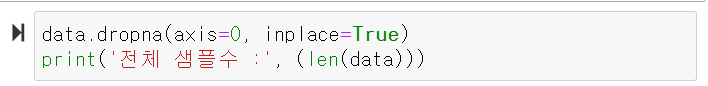

### 텍스트 정규화와 불용어 제거

**텍스트 정규화(text normalization) 란**, 같은 의미이지만 다른 표현으로 사용되는 단어들을 같은 단어로 통일시켜주는 역할로, it'll = it will, mustn't = must not 와 같은 의미의 표현들을 통일시키는 과정. 텍스트 정규화를 통해 기계의 연산량을 줄일 수 있다.

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


**"불용어"란?** 자연어 처리를 할 때 의미를 분석하고 요약하는 데는 거의 의미가 없는 단어이다.

* NLTK 에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거한다.

* 불용어 리스트에는 총 179개의 불용어가 존재

In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

데이터 전처리 함수 "preprocess_sentence"를 생성한다.

* 텍스트 소문자화

* html 태그 제거

* 괄호로 닫힌 문자열 (...) 제거

* 정규 표현식을 통해 각종 특수문자 제거

* 소유격 제거

이후, if 조건문을 이용하여 text에 있는 불용어를 제거하고, headlines에 있는 불용어는 제거하지 않음

* text 데이터만 불용어 제거하기 위해 함수의 인자로 remove_stopwords 추가

* Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 headlines에는 남아 있는 게 더 좋음

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [14]:
# 전처리 전, 후 결과 확인 
# 임의의 text와 headlines를 만들어 함수를 호출

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


Data 전체에 대해서 전처리를 수행!

* text의 경우 : 불용어를 제거

* headlines의 경우 : 불요어를 제거하지 않을것이므로 따로 호출해서 진행

 > text를 전처리하고 결과를 확인을 위해 상위 5개의 data출력
 
 > headlines에 대해서 불용어 제거를 수행하지 않는다는 의미에서 두번째 인자로 False를 넣어줌

In [16]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [19]:
clean_headlines = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


* 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있다. 이렇게 되면 샘플 자체가 빈 값을 가지게 된다.

* 이후 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체한다.

In [20]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [21]:
#Null 값이 생겼는지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

## Train data, test data split

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
headlines의 최소 길이 : 1
headlines의 최대 길이 : 16
headlines의 평균 길이 : 9.299532330215534


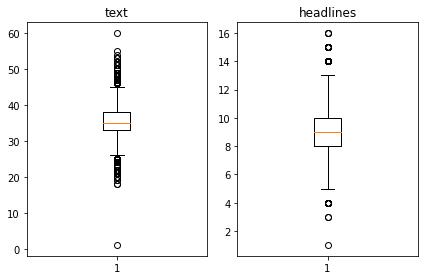

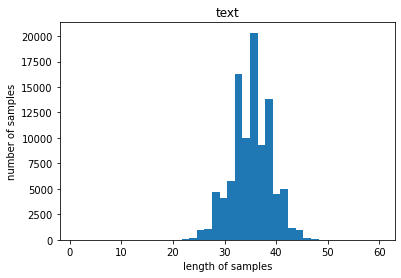

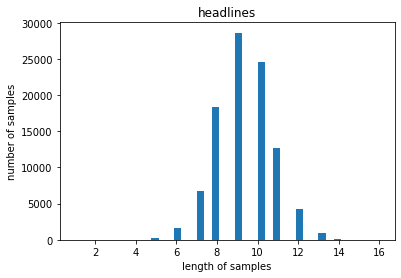

In [23]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

**그래프 해석**

- text의 경우 : 대체적으로 25 ~ 45 사이의 길이 분포 구성

- headlines의 경우 : 대체적으로 6 ~ 13 사이의 길이 분포 구성

In [24]:
# text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 정하기

text_max_len = 44
headlines_max_len = 12

In [25]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [26]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 44 이하인 샘플의 비율: 0.9933712891419276
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


### 최대 길이 적용

In [27]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플 수 :',(len(data)))

전체 샘플 수 : 96538


### Start token and End token 추가

* seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요

> Start token : sostoken

> End token : eostoken

In [28]:
# headlines 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


###  정수 시퀀스 만들기

In [29]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들rl
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

# 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플만들기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

[44053 67562 48468 ... 66917 68891 70258]


### Train data, test data split

In [30]:
# 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

테스트 데이터의 수 : 19307
훈련 데이터의 개수 : 77231
훈련 레이블의 개수 : 77231
테스트 데이터의 개수 : 19307
테스트 레이블의 개수 : 19307


### 정수 인코딩

#### 단어집합(vocabulary)만들기 및 정수 인코딩

In [31]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

* 현재 생성된 단어 집합은 src_tokenizer.word_index 에 저장되어 있다.

* 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외

* src_tokenizer.word_counts.items() 를 사용하여 등장 빈도수가 8회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

In [32]:
threshold = 7 # 등장 빈도수
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68780
등장 빈도가 6번 이하인 희귀 단어의 수: 46801
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21979
단어 집합에서 희귀 단어의 비율: 68.04448967723175
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.514836669166849


* encoder_input_train에는 6.8만여 개의 단어

* 등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 68% 차지

* 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치 3.5%밖에 되지 않음

등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거한다.

단어 집합의 크기를 10,000으로 제한한다.

In [33]:
src_vocab = 10000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 10,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [34]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[0])

[11, 106, 1285, 2272, 1607, 18, 4904, 374, 634, 655, 22, 208, 18, 659, 4904, 374, 634, 3847, 1153, 655, 254, 2292, 671, 872, 1958, 2, 1274, 229, 471, 832, 1736, 358]


#### 단어집합(vocabulary)만들기 및 정수 디코딩

In [35]:
# 전체 단어 집합과 각 단어에 대한 빈도수를 계산
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [36]:
# 등장 빈도수가 8회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29794
등장 빈도가 6번 이하인 희귀 단어의 수: 20340
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9454
단어 집합에서 희귀 단어의 비율: 68.26877894878164
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.378302970622025


In [37]:
tar_vocab = 1000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[0])
print('target')
print('decoder ',decoder_target_train[0])

input
input  [1, 3, 167, 50, 136, 766, 371]
target
decoder  [3, 167, 50, 136, 766, 371, 2]


* 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있다.

* decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이므로 길이가 0이 된 요악문의 실제 길이는 1로 나올 것이다.

* 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장하고 샘플들은 모두 삭제한다.

In [38]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 57
삭제할 테스트 데이터의 개수 : 14
훈련 데이터의 개수 : 77174
훈련 레이블의 개수 : 77174
테스트 데이터의 개수 : 19293
테스트 레이블의 개수 : 19293


### 패딩추가

In [40]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용(추상적 요약)

## 모델 설계

#### 인코더 설계

In [41]:
# 함수형 API를 이용해서 인코더 설계
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

#### 디코더 설계

In [42]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층 설계
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

In [43]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 44)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 44, 128)      1280000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 44, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 어텐션 메커니즘

In [44]:
# 어텐션 층을 만들고 위에 설계한 디코더 출력층을 수정하기

from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 44)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 44, 128)      1280000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 44, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련하기

In [45]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
302/302 [==============================] - 55s 93ms/step - loss: 3.0428 - val_loss: 2.7279
Epoch 2/50
302/302 [==============================] - 27s 90ms/step - loss: 2.6159 - val_loss: 2.5096
Epoch 3/50
302/302 [==============================] - 27s 91ms/step - loss: 2.4215 - val_loss: 2.3417
Epoch 4/50
302/302 [==============================] - 28s 92ms/step - loss: 2.2833 - val_loss: 2.2446
Epoch 5/50
302/302 [==============================] - 27s 91ms/step - loss: 2.1822 - val_loss: 2.1647
Epoch 6/50
302/302 [==============================] - 27s 91ms/step - loss: 2.0987 - val_loss: 2.1048
Epoch 7/50
302/302 [==============================] - 27s 91ms/step - loss: 2.0292 - val_loss: 2.0584
Epoch 8/50
302/302 [==============================] - 27s 91ms/step - loss: 1.9692 - val_loss: 2.0149
Epoch 9/50
302/302 [==============================] - 27s 91ms/step - loss: 1.9186 - val_loss: 1.9907
Epoch 10/50
302/302 [==============================] - 27s 91ms/step - loss: 1.873

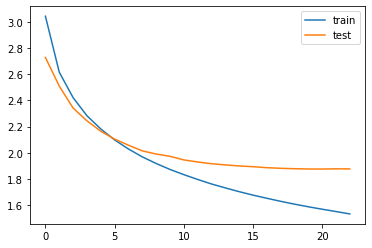

In [46]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현

In [47]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

#### 인코더 설계

In [48]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#### 디코더 설계

In [49]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

### word를 Sequence로 만드는 함수

In [50]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [51]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [71]:
for i in range(20, 40):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : arora entertainment lost legal battle john abraham said best wishes called heroes entertainment industry abused trust also made step producer films gul meter khan issues including non payment dues 
실제 요약 : my best to those who my in them 
예측 요약 :  was not on exit


원문 : indian deepika kumari defeated russia women bronze play win india medal indoor world cup none male indian could make das losing silver medallist second round 
실제 요약 : india deepika at world cup 
예측 요약 :  indian women team wins gold at asian games


원문 : reliance jio said government suffered revenue crore fy airtel vodafone idea violated licence norms jio claimed firms paid advance licence fee last quarter less amount jio added telecom department take action violating includes financial penalties even licence 
실제 요약 : crore loss to govt jio 
예측 요약 :  jio crore from


원문 : us president donald trump claimed rejected canadian pm justin trudeau request one one meeting slow pace trade talks trudeau tariffs high seem want

## Step 5. Summa을 이용해서 추출적 요약하기

* 패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 간단하게 구현 가능

### 패키지 설치

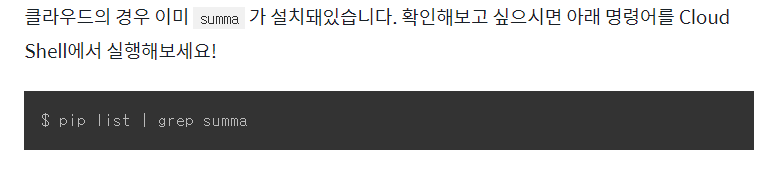

In [55]:
from summa.summarizer import summarize
import requests

# 매트릭스 시놉시스를 다운로드 해주세요.
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [56]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [59]:
text_str = data['text'][200]
print(summarize(text_str, ratio=0.5))

Australia's wicketkeeper-batswoman Alyssa Healy has said that the Australian team needs to be wary of India's women's T20I team captain Harmanpreet Kaur at the ICC Women's T20 World Cup next year.


In [60]:
text_str = data['text'][100]
print(summarize(text_str, ratio=0.8))

German multinational engineering and electronics firm Bosch has made its first investment in India in Bengaluru-based deep-tech startup SimYog. SimYog has raised about Ã¢ÂÂ¹6.3 crore in the funding round, with participation from early-stage venture capital firm Ideaspring Capital.


In [78]:
data['summary'] = data['text'].apply(lambda x: summarize(x, ratio=0.4))

In [79]:
data.sample(10)

,headlines,text,summary
57051,"2017 Nobel Laureates receive awards, $1 millio...",The 2017 Nobel Laureates were handed their med...,The 2017 Nobel Laureates were handed their med...
80889,"Company makes Ã¢ÂÂ¹17,000 gadget to tell user...",Japanese company Konica Minolta has created a ...,"For example, on detecting high readings of sme..."
78701,Uber to charge riders $15 to return lost items...,Cab-hailing startup Uber has started charging ...,Cab-hailing startup Uber has started charging ...
78972,NBA player does push-ups on 37-storey-high gla...,NBA side Golden State Warriors' Stephen Curry ...,Curry could manage only three push-ups before ...
74906,Dangal actress Sanya makes her debut at LakmÃ...,'Dangal' actress Sanya Malhotra made her ramp-...,Sanya wore a black skirt with flower appliques...
6807,RBI may introduce live video KYC for customer ...,The Reserve Bank of India may reportedly intro...,RBI may introduce a digital method that would ...
71041,FIR against 16 people for not building toilet ...,As many as 16 people from different villages h...,
25142,Rakul Preet to play Sridevi in NTR biopic: Rep...,Rakul Preet will be playing the role of late a...,Rakul Preet will be playing the role of late a...
56649,Man walks tightrope 200 feet up in the air fro...,"Nathan Paulin, a 23-year-old French slackliner...","Nathan Paulin, a 23-year-old French slackliner..."
80090,2 new subjects added to competency tests in Ma...,Science and English were added to the competen...,Science and English were added to the competen...


In [80]:
for i in range(40, 60):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("추출 요약 :", data['summary'][i])
    print("\n")

원문 : Ex-ICICI Bank CEO Chanda Kochhar said she's "utterly disappointed, hurt and shocked" by the bank's decision to terminate her. Kochhar said she served ICICI for 34 years with utmost honesty and integrity and that ultimately truth will prevail. Adding that she hasn't been given a copy of the independent probe report, Kochhar said none of ICICI's credit decisions are unilateral
실제 요약 : Shocked, hurt by ICICI's decision, truth will prevail: Kochhar
추출 요약 : Adding that she hasn't been given a copy of the independent probe report, Kochhar said none of ICICI's credit decisions are unilateral


원문 : Swedish multinational fast-fashion brand Hennes & Mauritz AB (H&M) has hired Christopher Wylie, the whistleblower who exposed Facebook's Cambridge Analytica data scandal. WylieÃ¢ÂÂs focus will be to help get better insights on customers, products and markets and support work on sustainable and ethical artificial intelligence, H&M spokesperson said. Wylie is a former employee of Cambridge Ana

# 결과

# 추상적 요약(Abstractive Summarization)

원문에 없던 문장이라도 핵심 문맥을 반영한 새로운 문장을 생성해서 원문을 요약하는 방법

[나름 잘되어 보이는 요약문]
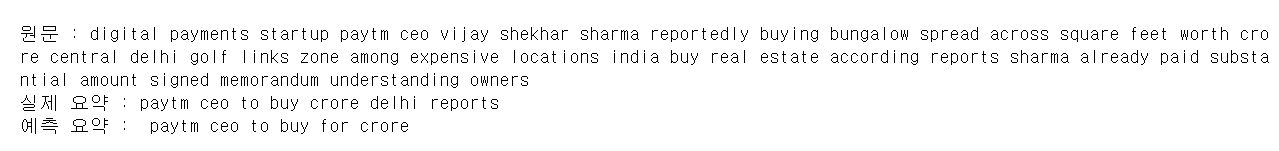

[전혀 관계없는 요약문]
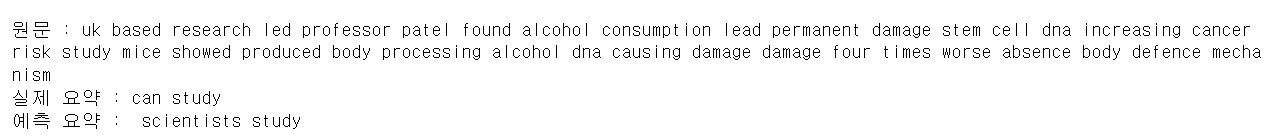

위의 결과들을 보면 추상적 요약에서는 몇단어의 키워드를 찾아내고 그것을 요약할 수 있는 새로운 단어를 만들어 요약을 하는 모습을 확인 할 수 있음
하지만 구체적으로 살펴보면 원문의 내용과는 연관성이 떨어지는 헤드라인을 만들어내는 것을 다수 확인 할 수 있고, 아예 관계 없는 요약(헤드라인)을 하는 모습도 많음.

# 추출적 요약(Extractive Summarization)

원문에서 중요한 핵심 문장 또는 단어를 몇개 뽑아서 이들로 구성된 요약문을 만드는 방법 

[나름 잘되어 보이는 요약문]
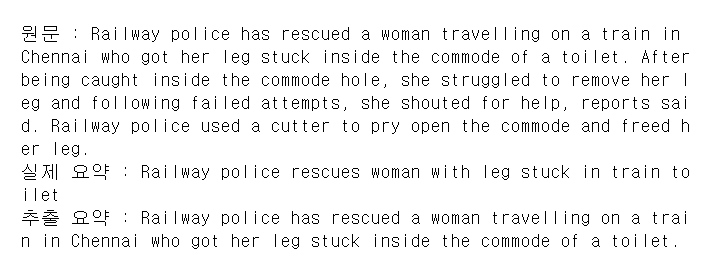

[전혀 관계없는 요약문]
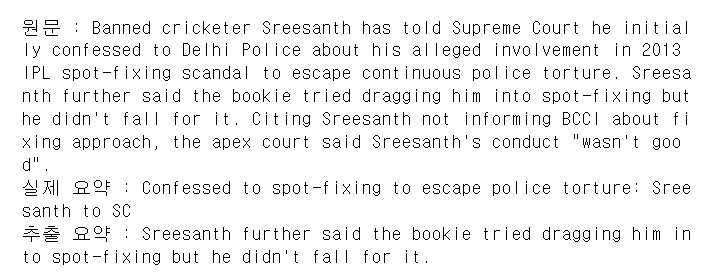

[특이한 부분]
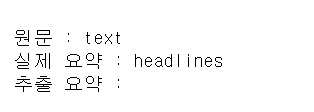

위의 결과를 보면 추출적 요약에서는 원문에서 중요한 핵심 문장 또는 단어 몇개를 뽑아서 이것으로 구성된 요약(헤드라인)된 것을 확인 할 수 있다. 
허나, 원문에는 있지만 실제 요약과 다른 부분을 요약을 하는 모습과 원문이 너무 짧으면 추출되는 단어가 없다는 점이 특히한 점이라고 보아집니다

**결론적으로 현재 설계된 모델로는 추출적 요약 모델이 추상적 요약 모델에 비해 더 성능이 좋다라고 생각한다**

# 회고 

번역기 기능을 갖춘 RNN 모델링을 한 프로젝트에서 인코더, 디코더 설계에 대한 이해도로 인해 뉴스 내용을 요약해주는 RNN 모델링이 막 어렵게 느껴지지는 않았다. 또한, 역시 cs231n에서 느꼈던 RNN의 랜덤성으로 인해 요약시 추상적 요약이 성능이 안나온게 아닐까 하는 의구심이 들었다 
또한, 하이퍼파라미터를 설정해도 그게 성능이 뛰지 않음을 프로젝트들을 진행하면서 느껴와서 다양한 기법들을 적용해 성능을 높이는 방법이 더 효율적일 것이라는 알수없는 강한 확신이 들었다. 